# Modificación de la clase normalisation.py de Aurora para trabajar en Kelvin

En este notebook vamos a realizar predicciones utilizando el modelo Aurora para datos HRES (High Resolution Analysis) del sistema IFS. En este ejemplo, descargaremos los datos de análisis HRES del 11 de mayo de 2022, con una resolución de 0.1 grados, desde el archivo de datos de investigación (RDA). Posteriormente, realizaremos un ajuste de estos datos para adaptarlos al modelo Aurora, el cual ha sido afinado con este tipo de datos. También modificaremos la clase normalisation.py de Aurora para trabajar en unidades Kelvin. Finalmente, cargaremos y ejecutaremos el modelo para visualizar las predicciones y compararlas con los datos de referencia. Durante este proceso, vamos a documentar detalladamente cada etapa para asegurar una mejor comprensión del flujo de trabajo.



## Descarga de los Datos

Para empezar, descargamos los datos desde el archivo de datos de investigación

In [2]:
from datetime import datetime
from pathlib import Path

import requests
import xarray as xr

# Aquí es donde se descargarán los datos.
download_path = Path("~/downloads/hres_0.1").expanduser()

# Día a descargar. Esto descargará todas las horas de ese día.
date = datetime(2022, 5, 11)

# Cada variable tiene un número asociado. Este es el número que se utilizará en la solicitud al RDA.
var_nums = {
    "2t": "167",  # Temperatura a 2 metros
    "10u": "165",  # Componente u del viento a 10 metros
    "10v": "166",  # Componente v del viento a 10 metros
    "msl": "151",  # Presión a nivel del mar
    "t": "130",  # Temperatura
    "u": "131",  # Componente u del viento (atmosférico)
    "v": "132",  # Componente v del viento (atmosférico)
    "q": "133",  # Humedad específica (atmosférica)
    "z": "129",  # Geopotencial
    "slt": "043",  # Tipo de suelo
    "lsm": "172",  # Máscara tierra-mar
}

# Construcción de las URLs para descargar los datos.
downloads: dict[Path, str] = {}
for v in ["2t", "10u", "10v", "msl", "z", "slt", "lsm"]:
    downloads[download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib")] = (
        f"https://data.rda.ucar.edu/ds113.1/"
        f"ec.oper.an.sfc/{date.year}{date.month:02d}/ec.oper.an.sfc.128_{var_nums[v]}_{v}."
        f"regn1280sc.{date.year}{date.month:02d}{date.day:02d}.grb"
    )
for v in ["z", "t", "u", "v", "q"]:
    for hour in [0, 6, 12, 18]:
        prefix = "uv" if v in {"u", "v"} else "sc"
        downloads[download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_{hour:02d}.grib")] = (
            f"https://data.rda.ucar.edu/ds113.1/"
            f"ec.oper.an.pl/{date.year}{date.month:02d}/ec.oper.an.pl.128_{var_nums[v]}_{v}."
            f"regn1280{prefix}.{date.year}{date.month:02d}{date.day:02d}{hour:02d}.grb"
        )

# Realizar las descargas.
for target, source in downloads.items():
    if not target.exists():
        print(f"Descargando {source}")
        target.parent.mkdir(parents=True, exist_ok=True)
        response = requests.get(source)
        response.raise_for_status()
        with open(target, "wb") as f:
            f.write(response.content)
print("¡Descargas finalizadas!")

¡Descargas finalizadas!


## Preparación del lote

Convertimos los datos descargados a un `aurora.Batch`, que es lo que el modelo requiere.

In [3]:
import numpy as np
import torch

from aurora import Batch, Metadata

# Cargar estos niveles de presión.
levels = (1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50)

def load_surf(v: str, v_in_file: str) -> torch.Tensor:
    """Cargar la variable de nivel de superficie o estática descargada `v` para las horas 00 y 06."""
    ds = xr.open_dataset(download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib"), engine="cfgrib")
    data = ds[v_in_file].values[:2]  # Usar las horas 00 y 06.
    data = data[None]  # Insertar una dimensión de batch.
    return torch.from_numpy(data)

def load_atmos(v: str) -> torch.Tensor:
    """Cargar la variable atmosférica descargada `v` para las horas 00 y 06."""
    ds_00 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_00.grib"), engine="cfgrib"
    )
    ds_06 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_06.grib"), engine="cfgrib"
    )
    # Seleccionar los niveles de presión correctos.
    ds_00 = ds_00[v].sel(isobaricInhPa=list(levels))
    ds_06 = ds_06[v].sel(isobaricInhPa=list(levels))
    data = np.stack((ds_00.values, ds_06.values), axis=0)
    data = data[None]  # Insertar una dimensión de batch.
    return torch.from_numpy(data)

# Extraer latitud y longitud de un archivo descargado arbitrario.
ds = xr.open_dataset(next(iter(downloads.keys())), engine="cfgrib")

batch = Batch(
    surf_vars={
        "2t": load_surf("2t", "t2m"),
        "10u": load_surf("10u", "u10"),
        "10v": load_surf("10v", "v10"),
        "msl": load_surf("msl", "msl"),
    },
    static_vars={
        # Las variables estáticas son constantes, así que solo las obtenemos una vez.
        "z": load_surf("z", "z")[0, 0],
        "slt": load_surf("slt", "slt")[0, 0],
        "lsm": load_surf("lsm", "lsm")[0, 0],
    },
    atmos_vars={
        "t": load_atmos("t"),
        "u": load_atmos("u"),
        "v": load_atmos("v"),
        "q": load_atmos("q"),
        "z": load_atmos("z"),
    },
    metadata=Metadata(
        lat=torch.from_numpy(ds.latitude.values),
        lon=torch.from_numpy(ds.longitude.values),
        time=(date.replace(hour=6),),
        atmos_levels=levels,
    ),
)

c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Ajuste resolución de datos
Rejillamos el batch reducimos la resolución para adaptarla a nuestros requisitos de cómputo.

In [4]:
batch = batch.regrid(res=0.5)

In [5]:
#comprobar la resolucion dps del regrid
batch.surf_vars["2t"].shape

torch.Size([1, 2, 361, 720])

# Adaptar nuestros datos 

In [7]:
import xarray as xr
import numpy as np
ds_sst = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")['thetao'].isel(time=slice(0,2),depth=slice(0,1))


In [8]:
latitude_to_interp = np.linspace(ds_sst.latitude.min().data, ds_sst.latitude.max().data, 361)
longitude_to_interp = np.linspace(ds_sst.longitude.min().data, ds_sst.longitude.max().data, 720)

# Interpolar la variable lsm para que coincida con la resolución del dataset
ds_sst_interp = ds_sst.interp(coords={"latitude": latitude_to_interp, "longitude": longitude_to_interp}, method="nearest")
ds_sst_interp_noNan = ds_sst_interp.fillna(ds_sst_interp.mean().data)

En esta sección, realizamos una interpolación de los datos de temperatura del mar (SST) para que coincidan con la resolución de nuestro batch. Además, llenamos los valores nulos con la media para evitar inconsistencias.

In [9]:
print("Valores de 2t (después de la conversión):")
print(f"Media: {batch.surf_vars['2t'].mean()}")
print(f"Mínimo: {batch.surf_vars['2t'].min()}")
print(f"Máximo: {batch.surf_vars['2t'].max()}")

Valores de 2t (después de la conversión):
Media: 278.7684020996094
Mínimo: 200.67881774902344
Máximo: 315.8576354980469


La media, el mínimo y el máximo de la temperatura (2t) se imprimen para verificar que los valores estén dentro del rango esperado, lo cual es esencial para asegurar que los datos son adecuados para el modelo.

## Carga y Ejecución del Modelo

Finalmente, cargamos el modelo y realizamos predicciones para dos pasos.

In [10]:
from aurora import AuroraHighRes, rollout, normalisation

model = AuroraHighRes()
model.load_checkpoint("microsoft/aurora", "aurora-0.1-finetuned.ckpt")
model.eval()
with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

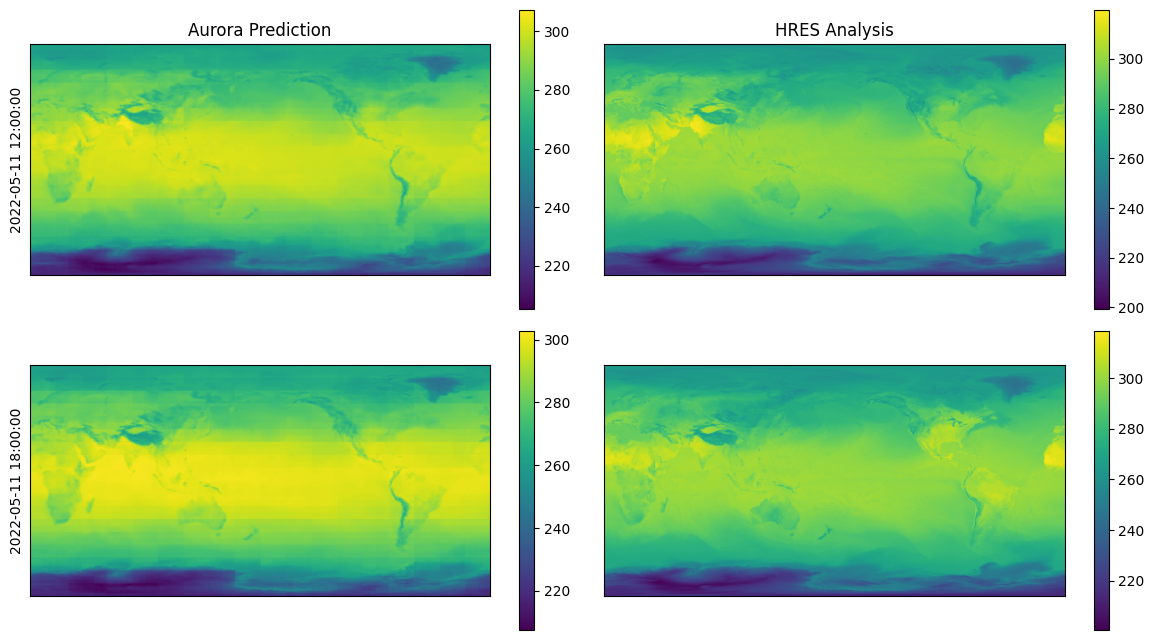

In [11]:
import matplotlib.pyplot as plt

truth = xr.open_dataset(download_path / date.strftime("surf_2t_%Y-%m-%d.grib"), engine="cfgrib")

fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    #ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy())
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ref = truth["t2m"][2 + i].values
    #ax[i, 1].imshow(ref - 273.15, vmin=-50, vmax=50)
    ax[i, 1].imshow(ref)
    if i == 0:
        ax[i, 1].set_title("HRES Analysis")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    fig.colorbar(ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy()), ax=ax[i, 0])
    fig.colorbar(ax[i, 1].imshow(truth["t2m"][2 + i].values), ax=ax[i, 1])
#coloca una barra de colores para cada imshow

plt.tight_layout()

## Conclusión

En este notebook, hemos trabajado con el modelo Aurora para realizar predicciones basadas en datos HRES de IFS. A lo largo del proceso, descargamos, preparamos e interpolamos los datos para su uso, y ejecutamos el modelo para generar las predicciones. Se puede observar claramente que es importante modificar la clase normalisation.py de Aurora para trabajar en Kelvin y así asegurar una mayor precisión en las predicciones. Cada ajuste y modificación realizados durante el proceso son esenciales para lograr que el modelo funcione adecuadamente con los datos en este formato específico.